In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [2]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [3]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,88
229447,2011,1,10
156483,2012,1,50
76159,2013,1,8
76160,2013,1,16


In [4]:
bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

# #create dataframe for amount * count to show cumulative percent by volume of loans
# amtXcnt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count()) #* bank_df.amount
# amtXcnt_df['amount'] = amtXcnt_df.index
# amtXcnt_df['vol'] = amtXcnt_df.amount * amtXcnt_df.pct_amt
# amtXcnt_df['count'] = amtXcnt_df.pct_amt
# amtXcnt_df.drop('pct_amt', axis=1, inplace=True)
# amtXcnt_df['pct'] = amtXcnt_df.vol / amtXcnt_df.vol.sum()
# amtXcnt_df['cumul_pct'] = amtXcnt_df.pct.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()


# #create dataframe for amount * count to show cumulative percent by volume of loans
# incXcnt_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count()) #* bank_df.amount
# incXcnt_df['income'] = incXcnt_df.index
# incXcnt_df['vol'] = incXcnt_df.income * incXcnt_df.pct_inc
# incXcnt_df['count'] = incXcnt_df.pct_inc
# incXcnt_df.drop('pct_inc', axis=1, inplace=True)
# incXcnt_df['pct'] = incXcnt_df.vol / incXcnt_df.vol.sum()
# incXcnt_df['cumul_pct'] = incXcnt_df.pct.cumsum()

In [7]:
print(bank_df.head()) #check dataframe for columns
print(inc_df.head())

       year  income  amount      mult       pct_amt  cumul_amt_pct   pct_inc  \
7036   2014      56       7  0.125000  1.892840e-07   1.892840e-07  0.000004   
9916   2014      67       8  0.119403  2.163245e-07   4.056085e-07  0.000004   
1090   2014      25       8  0.320000  2.163245e-07   6.219331e-07  0.000002   
1468   2014      28       9  0.321429  2.433651e-07   8.652982e-07  0.000002   
33498  2014     140      10  0.071429  2.704057e-07   1.135704e-06  0.000009   

       cumul_inc_pct  
7036        0.000004  
9916        0.000008  
1090        0.000009  
1468        0.000011  
33498       0.000020  
        year  income  amount       pct_amt  cumul_amt_pct       pct_inc  \
0       2014       1      88  6.783152e-07   6.783152e-07  1.704434e-08   
229447  2011       1      10  7.708127e-08   7.553965e-07  1.704434e-08   
156483  2012       1      50  3.854064e-07   1.140803e-06  1.704434e-08   
76159   2013       1       8  6.166502e-08   1.202468e-06  1.704434e-08   
76160 

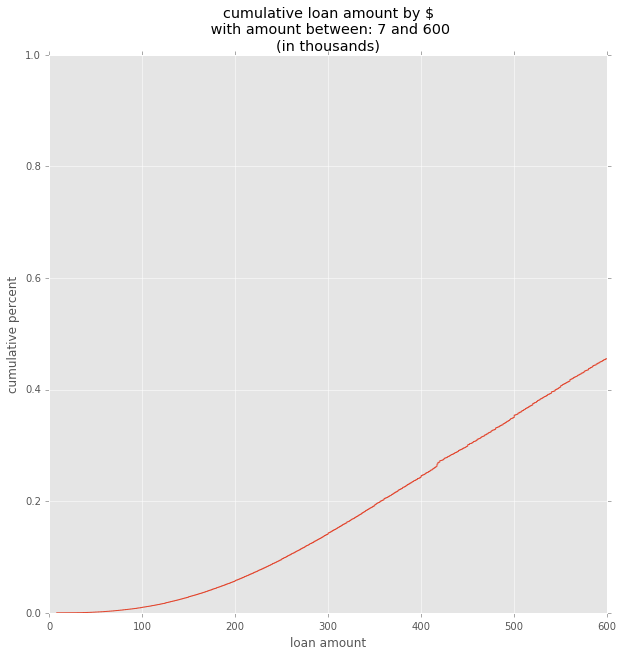

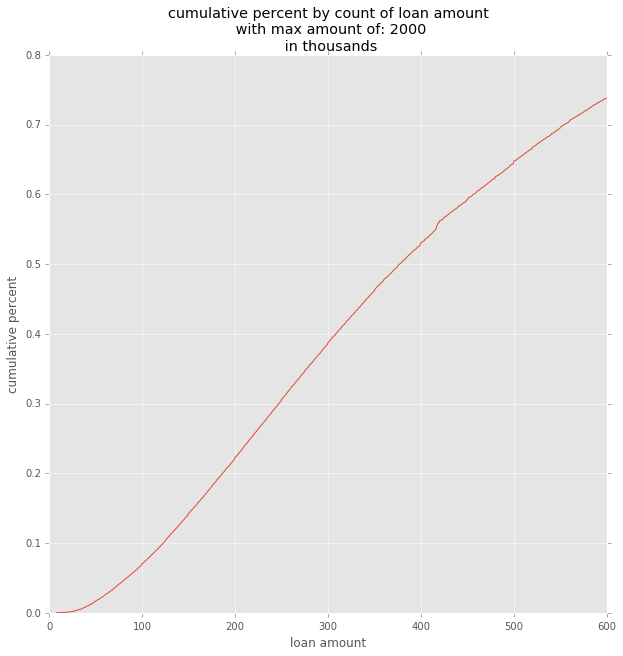

In [ ]:
#FIXME add cutoff field name and cutoff value to title
#graph cumulative sum of % of income and % of loan amount 
amt_min = bank_df.amount.min()
amt_max = 600#bank_df.amount.max()

y = bank_df.cumul_amt_pct[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
x = bank_df.amount[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
cumul_pct = plt.figure(figsize=(10,10))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative loan amount by $\n with amount between: {amt_min} and {amt_max}\n(in thousands)'.format(amt_min=amt_min, amt_max=amt_max))
plt.ylabel('cumulative percent')
plt.xlabel('loan amount')
plt.show(cumul_pct)

#y1 = bank_df.cumul_cnt_pct_amt[bank_df[cut_field] < amt_cutoff]
x1 = cnt_amt_df.amount[(cnt_amt_df.amount < amt_max) & (cnt_amt_df.amount > amt_min)]
y1 = cnt_amt_df.cumul_pct_cnt[(cnt_amt_df.amount < amt_max) & ( cnt_amt_df.amount > amt_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
plt.xlabel('loan amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of loan amount\n with max amount of: {amt}\n in thousands'.format(amt=amt_cutoff))
plt.show(cumul_cnt)


#FIXME modify these graphs by reducing the range of the x axis to see the cumulative curve better
#measureing the $ value of loans shows a high degree of skew due to very large loan amounts
#cutting the tail off the data may be more informative
#the majority of loans by count are under 450-500k, but the raw $ value majority is closer to 2million

In [ ]:
from math import log, sqrt
amt_dist = pd.DataFrame(bank_df.groupby('amount').mult.count())
amt_dist.rename(columns={'mult':'count_amt'},inplace=True)
amt_dist['amount'] = amt_dist.index
amt_dist['amt_log'] = amt_dist.amount.apply(log)
amt_dist['amt_sqrt'] = amt_dist.amount.apply(sqrt)
amt_dist.head()
amt_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y1 = amt_dist.count_amt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
amt_x1 = amt_dist.amount[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]


plt.plot(amt_x1,amt_y1)
plt.show(amt_fig)

#plot logs of amount
log_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y2 = amt_dist.amt_log[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y2)
plt.show(log_fig)

#plot sqrt of amount
sqrt_fig = plt.figure(figsize=(10,10))
amt_y3 = amt_dist.amt_sqrt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y3)
plt.show(sqrt_fig)



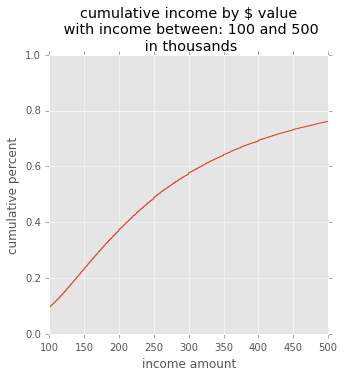

In [26]:
#showing cumulative percent of count of loans by income
#inc_cutoff allows trims max end of distribution
inc_min = 100
inc_max = 500
y = inc_df.cumul_inc_pct[(inc_df.income < inc_max) & (inc_df.income > inc_min)]
x = inc_df.income[(inc_df.income < inc_max) &(inc_df.income > inc_min)]

cumul_inc = plt.figure(figsize=(5,5))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative income by $ value\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.ylabel('cumulative percent')
plt.xlabel('income amount')
plt.show(cumul_inc)


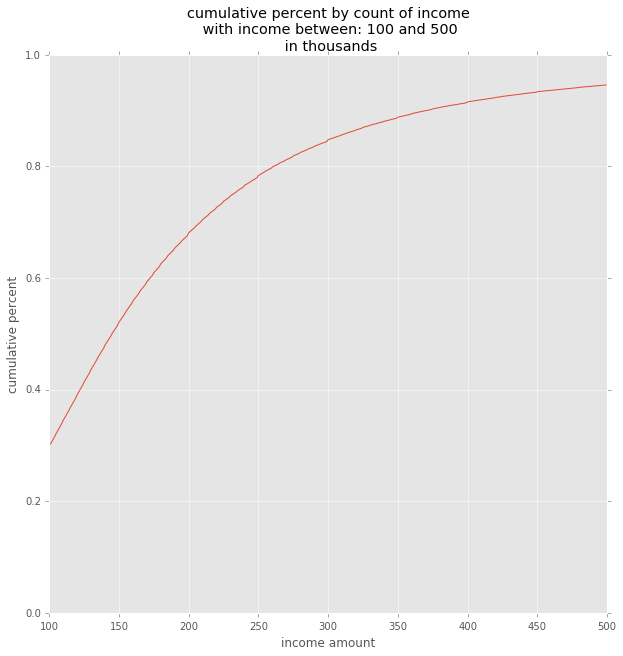

In [27]:
x1 = cnt_inc_df.income[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
y1 = cnt_inc_df.cumul_pct_cnt[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.xlabel('income amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of income\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.show(cumul_cnt)

437.434185441 std
485.58242624 mean
377.0 median
2500.0 max mult
0.0352564102564 min mult
1720.0 98%
612.0 q3
217.0 q1
55.0 02%
395.0 iqr
-375.5 min_q 1204.5 max_q


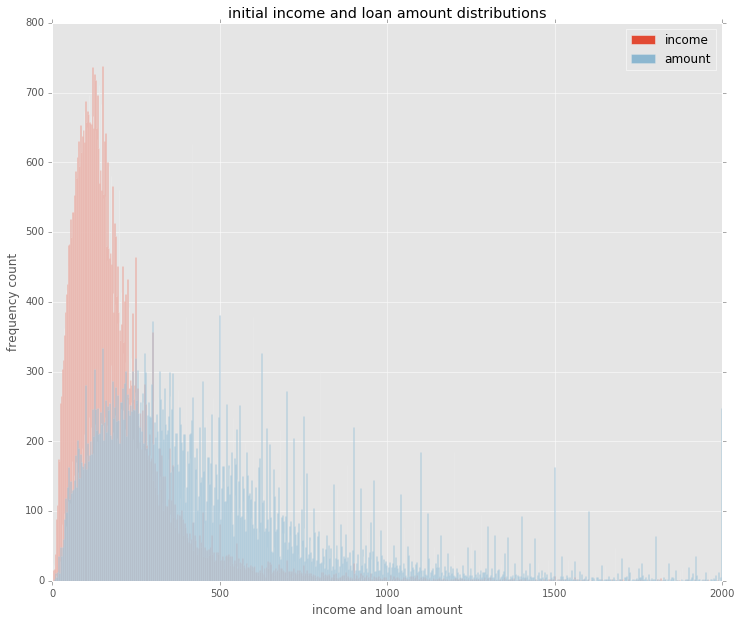

In [54]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr #potential lower bound for quality
max_q = q3 + 1.5*iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

std 78.983270855
mean 105.759130435
median 90.0
max_mult 38.4285714286
min_mult 0.32
q98 319.1
q02 21.98
q75 127.0
q25 59.0
iqr 68.0
min_q -43.0
max_q 229.0


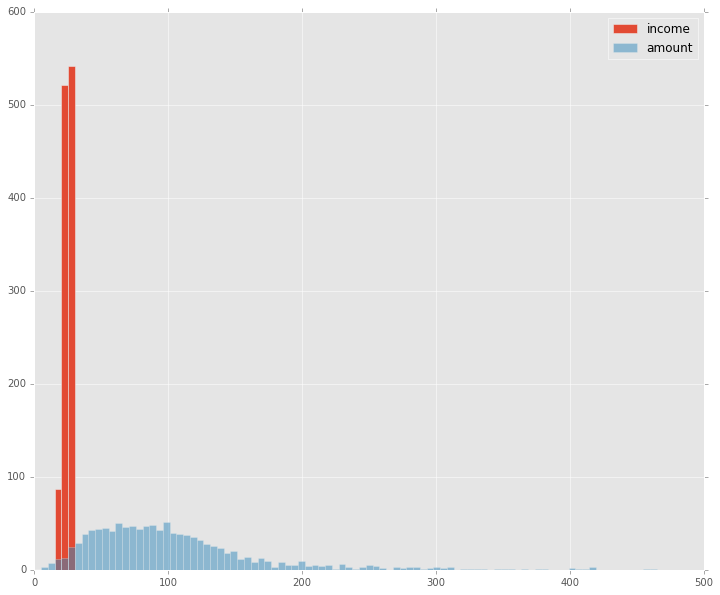

In [13]:
bin_2030 = bank_df[(bank_df.income >=20) & (bank_df.income < 30)] #create bin of 20 to 30k income
#generate descriptive statistics and store for later comparison
bin_2030_stats = OrderedDict({})
bin_2030_stats['std']= bin_2030.amount.std()
bin_2030_stats['mean'] = bin_2030.amount.mean()
bin_2030_stats['median'] = bin_2030.amount.median()
bin_2030_stats['max_mult'] = bin_2030.mult.max()
bin_2030_stats['min_mult'] = bin_2030.mult.min()
bin_2030_stats['q98'] = bin_2030.amount.quantile(q=.98)
bin_2030_stats['q02'] = bin_2030.amount.quantile(q=.02)
bin_2030_stats['q75'] = bin_2030.amount.quantile(q=.75)
bin_2030_stats['q25'] = bin_2030.amount.quantile(q=.25)
bin_2030_stats['iqr'] = bin_2030_stats['q75'] - bin_2030_stats['q25']
bin_2030_stats['min_q'] = bin_2030_stats['q25'] - 1.5 * bin_2030_stats['iqr']
bin_2030_stats['max_q'] = bin_2030_stats['q75'] + 1.5 * bin_2030_stats['iqr']

for key, value in bin_2030_stats.items():
    print(key, value)

amt = bin_2030.amount
inc = bin_2030.income
bins = np.linspace(0,500, 100)
#print(bins)
bin_viz = plt.figure(figsize=(12,10))
plt.hist(inc, bins, label='income', alpha=1)
plt.hist(amt, bins, label='amount', alpha=.5)

plt.legend(loc='upper right')
plt.show(bin_viz)
#FIXME add two boxplot viz

std 330.913083864
mean 229.642857143
median 135.5
max_mult 2500.0
min_mult 1.88888888889
q98 1248.92
q02 29.0
q75 236.75
q25 82.75
iqr 154.0
min_q -148.25
max_q 467.75
count of loans 98
pct of total loans 0.128678160165


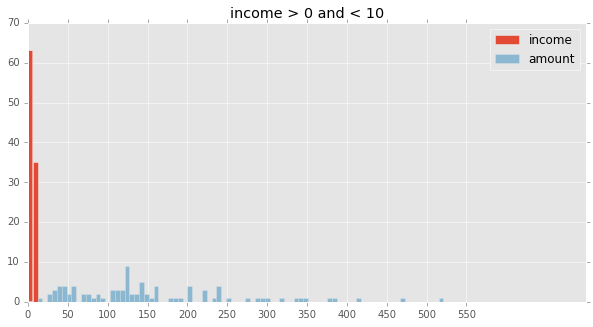

std 117.924100055
mean 107.889692586
median 85.0
max_mult 156.25
min_mult 0.32
q98 373.88
q02 23.0
q75 125.0
q25 54.0
iqr 71.0
min_q -52.5
max_q 231.5
count of loans 1659
pct of total loans 2.17833742565


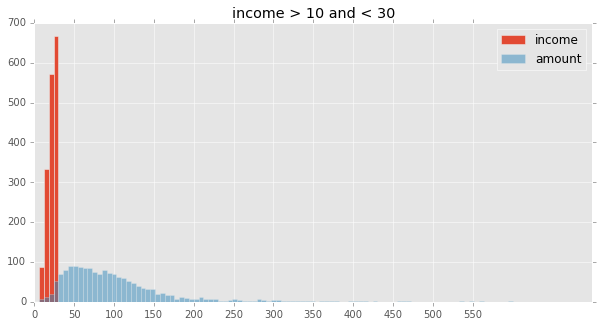

std 87.1589775433
mean 139.281753367
median 129.0
max_mult 37.4791666667
min_mult 0.204081632653
q98 323.0
q02 29.0
q75 181.0
q25 81.0
iqr 100.0
min_q -69.0
max_q 331.0
count of loans 3787
pct of total loans 4.97249176066


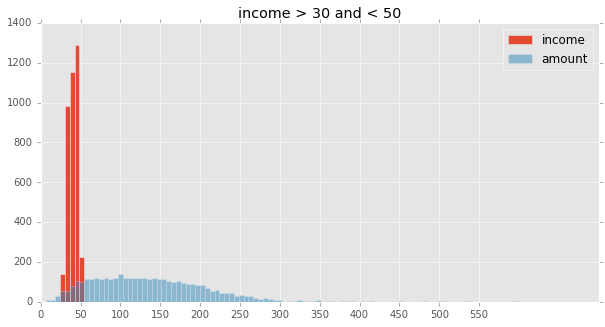

std 102.194511201
mean 187.68133769
median 179.0
max_mult 26.8070175439
min_mult 0.119402985075
q98 395.0
q02 38.04
q75 249.0
q25 113.0
iqr 136.0
min_q -91.0
max_q 453.0
count of loans 5203
pct of total loans 6.8317598708


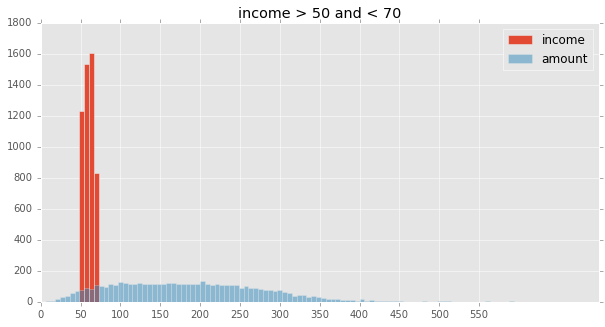

std 118.734305332
mean 234.476182681
median 224.0
max_mult 24.0
min_mult 0.128205128205
q98 480.0
q02 50.0
q75 311.0
q25 145.0
iqr 166.0
min_q -104.0
max_q 560.0
count of loans 6109
pct of total loans 8.0213763311


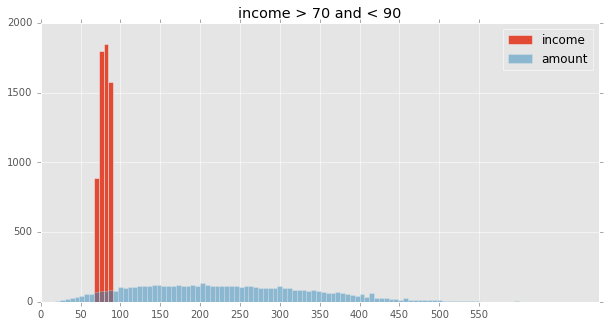

std 137.468066354
mean 280.211327649
median 266.0
max_mult 18.3
min_mult 0.103092783505
q98 580.0
q02 62.0
q75 368.0
q25 175.0
iqr 193.0
min_q -114.5
max_q 657.5
count of loans 6568
pct of total loans 8.62406281595


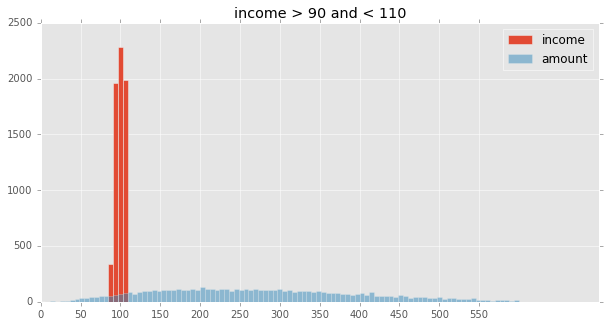

std 155.571067366
mean 330.006802721
median 312.0
max_mult 16.1290322581
min_mult 0.215517241379
q98 667.0
q02 79.22
q75 430.0
q25 212.0
iqr 218.0
min_q -115.0
max_q 757.0
count of loans 6762
pct of total loans 8.87879305138


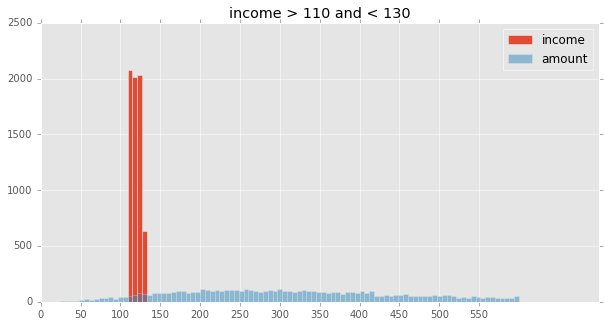

std 177.176463158
mean 375.863522798
median 354.0
max_mult 20.273381295
min_mult 0.0714285714286
q98 749.94
q02 96.0
q75 495.0
q25 244.0
iqr 251.0
min_q -132.5
max_q 871.5
count of loans 6404
pct of total loans 8.40872385404


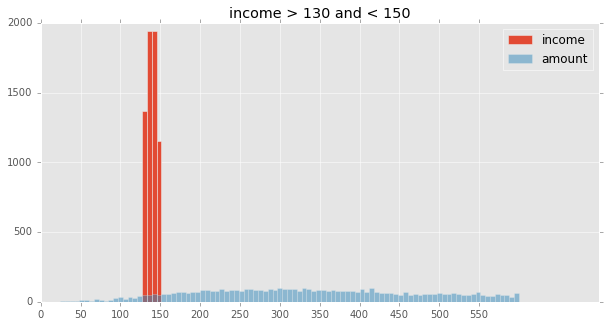

std 192.156864282
mean 422.349573257
median 398.0
max_mult 12.0481927711
min_mult 0.15243902439
q98 870.54
q02 110.0
q75 547.0
q25 279.0
iqr 268.0
min_q -123.0
max_q 949.0
count of loans 5624
pct of total loans 7.38455074253


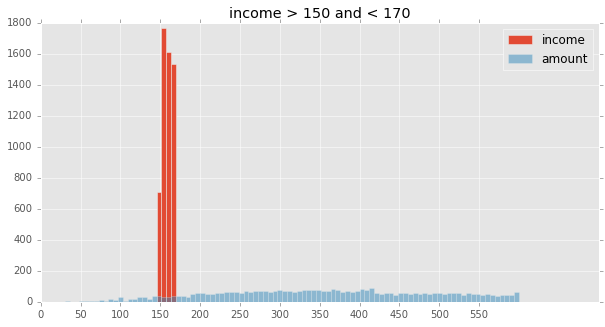

std 210.420131035
mean 460.8584532
median 436.0
max_mult 12.9888268156
min_mult 0.0899470899471
q98 950.08
q02 117.92
q75 592.0
q25 305.0
iqr 287.0
min_q -125.5
max_q 1022.5
count of loans 4797
pct of total loans 6.29866463583


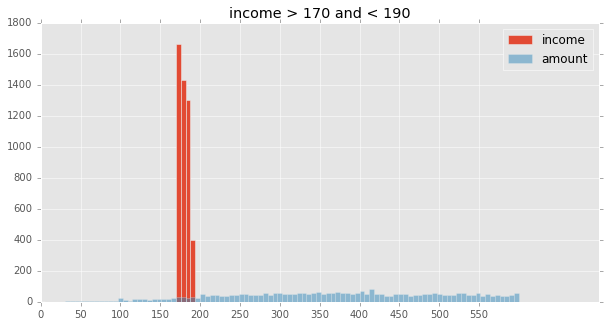

std 233.932823261
mean 511.50060518
median 486.0
max_mult 14.2718446602
min_mult 0.196078431373
q98 1077.2
q02 133.0
q75 643.5
q25 340.0
iqr 303.5
min_q -115.25
max_q 1098.75
count of loans 4131
pct of total loans 5.42417836369


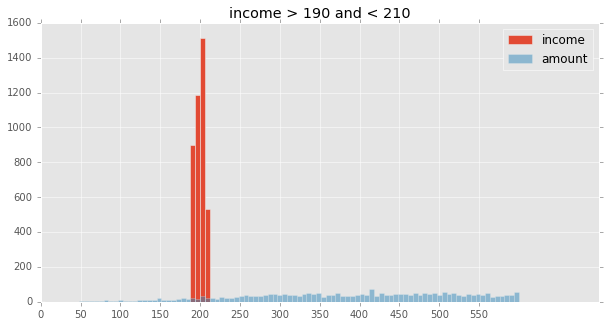

std 244.748858657
mean 550.78049466
median 522.0
max_mult 7.64444444444
min_mult 0.201834862385
q98 1120.86
q02 140.0
q75 694.0
q25 374.0
iqr 320.0
min_q -106.0
max_q 1174.0
count of loans 3558
pct of total loans 4.67180503946


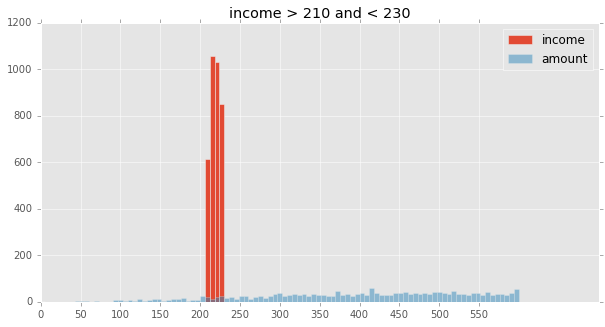

std 274.796600381
mean 598.81797005
median 565.0
max_mult 16.743697479
min_mult 0.160642570281
q98 1274.44
q02 150.0
q75 744.0
q25 413.0
iqr 331.0
min_q -83.5
max_q 1240.5
count of loans 3005
pct of total loans 3.94569256424


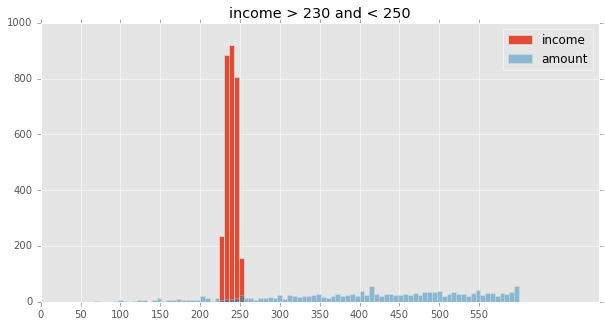

std 286.24791228
mean 643.638953041
median 608.0
max_mult 7.8431372549
min_mult 0.22265625
q98 1350.3
q02 167.88
q75 798.0
q25 445.0
iqr 353.0
min_q -84.5
max_q 1327.5
count of loans 2598
pct of total loans 3.41128428682


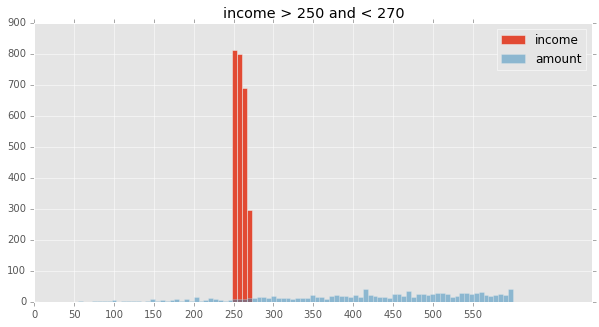

std 314.782330605
mean 687.18041958
median 634.0
max_mult 7.31010452962
min_mult 0.249110320285
q98 1451.2
q02 172.0
q75 864.0
q25 464.0
iqr 400.0
min_q -136.0
max_q 1464.0
count of loans 2145
pct of total loans 2.81647605667


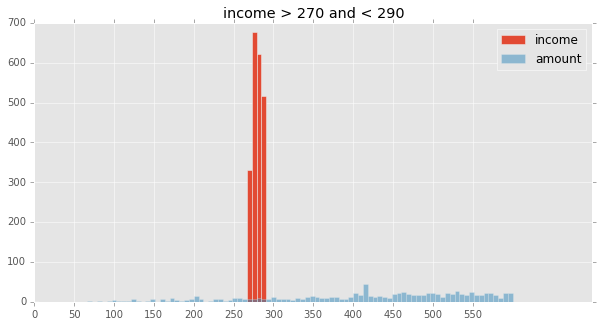

std 335.500412049
mean 729.554525627
median 671.5
max_mult 7.70169491525
min_mult 0.13468013468
q98 1535.34
q02 186.32
q75 940.0
q25 490.0
iqr 450.0
min_q -185.0
max_q 1615.0
count of loans 1834
pct of total loans 2.40811985451


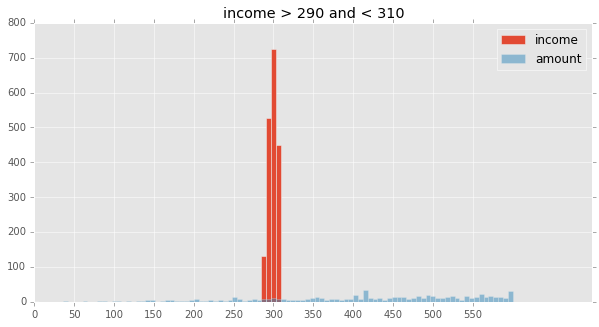

std 356.7954155
mean 768.35852982
median 708.0
max_mult 7.86392405063
min_mult 0.28125
q98 1603.44
q02 200.0
q75 990.75
q25 506.5
iqr 484.25
min_q -219.875
max_q 1717.125
count of loans 1442
pct of total loans 1.89340721386


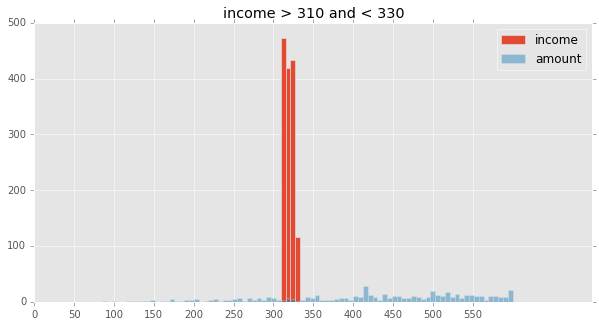

std 377.734631946
mean 802.976588629
median 740.0
max_mult 7.25757575758
min_mult 0.14501510574
q98 1757.3
q02 213.6
q75 1040.0
q25 528.75
iqr 511.25
min_q -238.125
max_q 1806.875
count of loans 1196
pct of total loans 1.57039877099


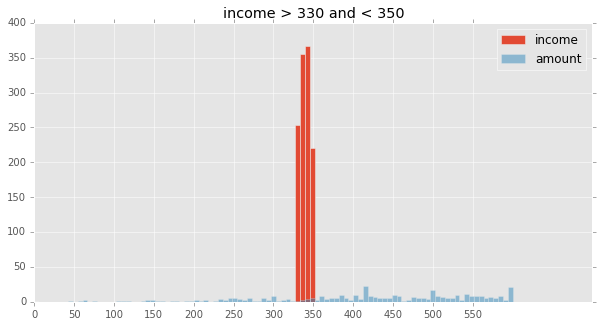

std 411.03310262
mean 846.682438581
median 753.0
max_mult 8.5
min_mult 0.178272980501
q98 1867.76
q02 204.8
q75 1100.0
q25 542.0
iqr 558.0
min_q -295.0
max_q 1937.0
count of loans 1099
pct of total loans 1.44303365328


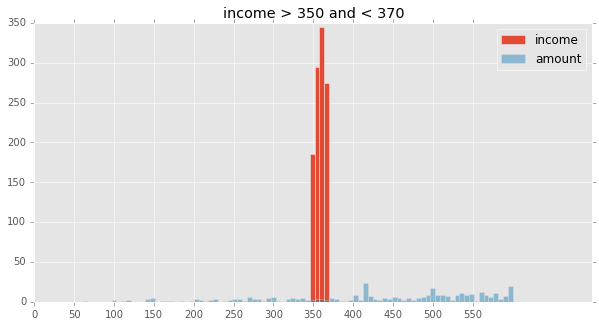

std 427.445560646
mean 875.581778266
median 810.0
max_mult 8.78378378378
min_mult 0.220779220779
q98 1916.0
q02 220.2
q75 1132.5
q25 559.0
iqr 573.5
min_q -301.25
max_q 1992.75
count of loans 911
pct of total loans 1.19618167255


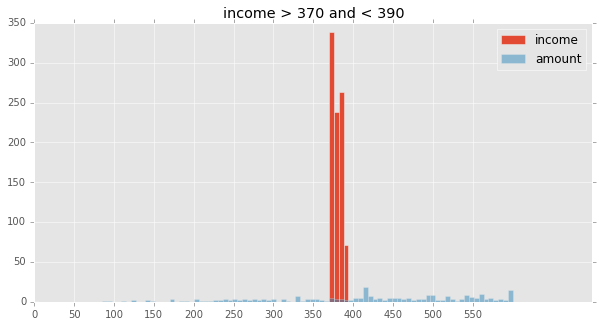

std 493.663112584
mean 907.157360406
median 840.0
max_mult 16.4141414141
min_mult 0.178571428571
q98 2000.0
q02 208.88
q75 1137.0
q25 568.75
iqr 568.25
min_q -283.625
max_q 1989.375
count of loans 788
pct of total loans 1.03467745112


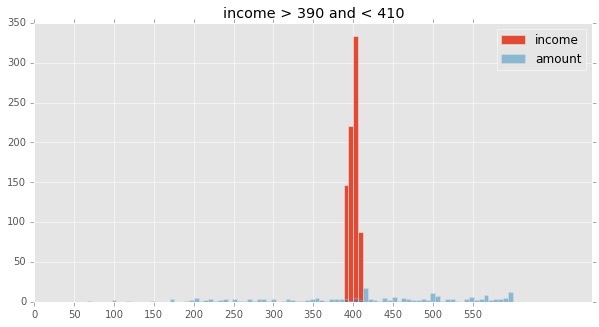

std 444.287268772
mean 956.300165837
median 920.0
max_mult 5.88221153846
min_mult 0.224096385542
q98 2000.0
q02 272.04
q75 1250.0
q25 606.5
iqr 643.5
min_q -358.75
max_q 2215.25
count of loans 603
pct of total loans 0.791764597749


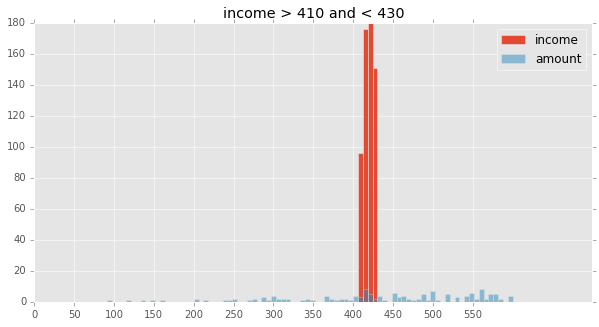

std 523.366261669
mean 950.327552987
median 878.0
max_mult 11.7511520737
min_mult 0.0925925925926
q98 2000.0
q02 171.08
q75 1259.0
q25 570.0
iqr 689.0
min_q -463.5
max_q 2292.5
count of loans 519
pct of total loans 0.681469031894


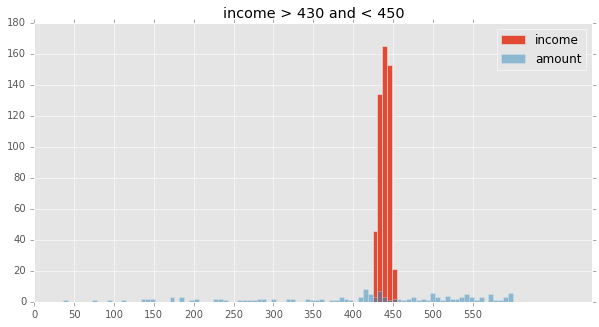

std 472.251920969
mean 954.661733615
median 880.0
max_mult 5.55555555556
min_mult 0.258064516129
q98 1998.24
q02 232.4
q75 1252.0
q25 590.0
iqr 662.0
min_q -403.0
max_q 2245.0
count of loans 473
pct of total loans 0.621069079163


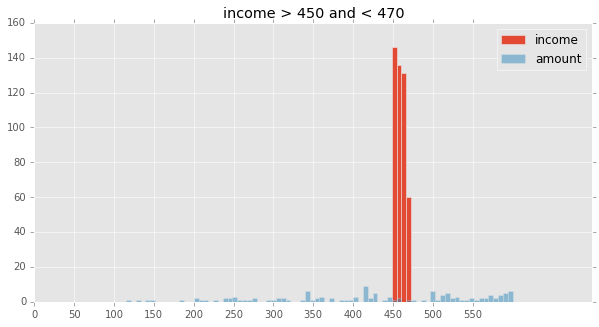

std 539.788470813
mean 1064.75352113
median 1000.0
max_mult 6.96428571429
min_mult 0.145833333333
q98 2330.0
q02 227.0
q75 1412.75
q25 651.0
iqr 761.75
min_q -491.625
max_q 2555.375
count of loans 426
pct of total loans 0.559356083982


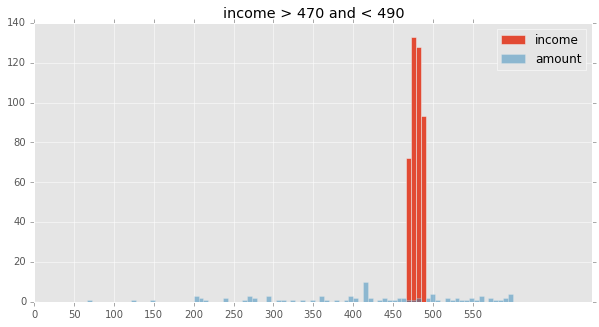

In [164]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 10
bin_step = 20
pct_of_loans = OrderedDict({})
while bin_max < 501:
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of 20 to 30k income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    for key, value in bin_stats.items():
        print(key,value)
    amt = graph_bin.amount
    inc = graph_bin.income
    xmin = 0
    xmax = 600
    xsteps= 100
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']

In [165]:
#make data adjustments and calculate desc stat deltas and regraph
#use IQR and quality edits seperately (copy dataframe first)
#use this work to refine income bins and associated loan amount distributions


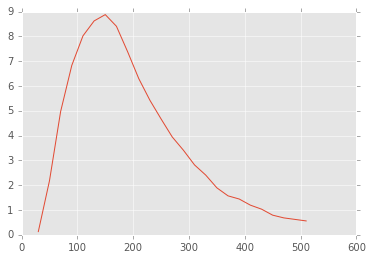

In [166]:
#graph percent of loans by top of income bin
y = []
x = []
for key, value in pct_of_loans.items():
    y.append(value)
    x.append(key)
plt.plot(x,y)


In [ ]:
#exclude data with quality edit fails